# Define Running Mode

- 'full_dataset = True' to use the full data set. If 'full_dataset = True', then a data set containing only data one year of the hobbies sales in TX2.  
    
- 'submit_to_kaggle = True' to submit the forecasts to Kaggle.  


In [1]:
full_dataset = True
submit_to_kaggle = False


# Import Packages

In [2]:
import utils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import time
from sklearn.metrics import mean_squared_error
import lightgbm as lgb

# Data Import and Preparation

In [3]:
if full_dataset:
    prefix = 'full_dataset'
else:
    prefix = 'subset'

df_merged = pd.read_csv(
    f'{utils.get_m5_root_dir()}/data/feature_engineering/{prefix}_df_merged.csv')

scaling_factors_rmsse = pd.read_csv(
    f'{utils.get_m5_root_dir()}/data/weights/scaling_factors_rmsse.csv')

weights_wrmsse = pd.read_csv(
    f'{utils.get_m5_root_dir()}/data/weights/weights_for_wrmsse.csv')


In [4]:
# downcast numerical values to reduce mem usage
df_merged = utils.reduce_mem_usage(df_merged)

Mem. usage of decreased to 4912.94 Mb (64.7% reduction)


# Delete Data where Item was not up for Sale

Item is not up for sale when price is NA.

In [5]:
print(df_merged.shape)

df_merged = df_merged.loc[df_merged['sell_price'] > 0]

print(df_merged.shape)

(53662400, 34)
(44307636, 34)


# Model Training & Forecasting (LightGBM)

In [6]:
# Custom Loss & valid for asymetric rmse
def custom_mse_asymmetric_loss(y_pred, y_true):
    y_true = y_true.get_label()
    residual = (y_true - y_pred).astype("float")
    grad = np.where(residual < 0, -2 * residual, -2 * residual * 1.1)
    hess = np.where(residual < 0, 2, 2 * 1.1)
    return grad, hess


def custom_rmse_asymmetric_valid(y_pred, y_true, tmp=None):
    y_true = y_true.get_label()
    residual = (y_true - y_pred).astype("float")
    loss = np.where(residual < 0, (residual ** 2), (residual ** 2) * 1.1)
    return "custom_mse_asymmetric_eval", np.sqrt(np.mean(loss)), False

In [7]:
# TODO: proper feature selection (e.g. random forrest)
# for now: hardcoded list of features

cat_features = [
    'item_id',
    'dept_id',
    'cat_id',
    'store_id',
    'state_id',
    'year',
    'month',
    'day',
    'is_weekend',
    'wday',
    'event_name_1',
    'event_type_1',
    'event_name_2',
    'event_type_2',
    'snap_CA',
    'snap_TX',
    'snap_WI',
    'up_for_sale'
]

num_features = [
    'sell_price',
    'lag_t28',
    'rolling_kurt_t28',
    'rolling_skew_t28',
    'rolling_mean_t28',
    'rolling_std_t28',
    'price_change_t1',
    'price_change_t30',
    'rolling_price_std_t28',
]

features = cat_features + num_features

In [8]:
x_train = df_merged[df_merged['date'] <= '2016-03-27'][features]
y_train = df_merged[df_merged['date'] <= '2016-03-27']['sale']


x_val = df_merged.loc[df_merged['data_type'] ==
                      'train'].loc[df_merged['date'] > '2016-03-27'][features]
y_val = df_merged.loc[df_merged['data_type'] ==
                      'train'].loc[df_merged['date'] > '2016-03-27']['sale']

x_pred = df_merged[(df_merged['data_type'] == 'validation')][features]


print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(x_pred.shape)

(42600196, 27)
(42600196,)
(853720, 27)
(853720,)
(853720, 27)


In [9]:
# create datasets
train_data = lgb.Dataset(x_train, label=y_train,
                         categorical_feature=cat_features, free_raw_data=False,
                       )
validation_data = lgb.Dataset(
    x_val, label=y_val, categorical_feature=cat_features, free_raw_data=False, reference=train_data,
)

In [10]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'seed': 10,
    'learning_rate': 0.15,
    'bagging_fraction': 0.75,
    'bagging_freq': 10,
    'max_bin': 128,
    'feature_fraction ': 0.75,
}

evals_result = {}  # to record eval results for plotting

gbm = lgb.train(params, train_data, valid_sets=[train_data, validation_data],
                evals_result=evals_result, num_boost_round=1000,
                verbose_eval=25, early_stopping_rounds=20,
                fobj=custom_mse_asymmetric_loss,
                feval=custom_rmse_asymmetric_valid
               )




c:\users\domin\anaconda3\envs\predicting-sales-data\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[25]	training's custom_mse_asymmetric_eval: 2.74544	valid_1's custom_mse_asymmetric_eval: 2.25419
[50]	training's custom_mse_asymmetric_eval: 2.67122	valid_1's custom_mse_asymmetric_eval: 2.23414
[75]	training's custom_mse_asymmetric_eval: 2.63343	valid_1's custom_mse_asymmetric_eval: 2.22853
[100]	training's custom_mse_asymmetric_eval: 2.60601	valid_1's custom_mse_asymmetric_eval: 2.22428
[125]	training's custom_mse_asymmetric_eval: 2.5872	valid_1's custom_mse_asymmetric_eval: 2.22166
[150]	training's custom_mse_asymmetric_eval: 2.57146	valid_1's custom_mse_asymmetric_eval: 2.21909
[175]	training's custom_mse_asymmetric_eval: 2.55846	valid_1's custom_mse_asymmetric_eval: 2.21748
[200]	training's custom_mse_asymmetric_eval: 2.54459	valid_1's custom_mse_asymmetric_eval: 2.21614
Early stopping, best iteration is:
[199]	training's custom_mse_asymmetric_eval: 2.54503	valid_1's custom_mse_asymmetric_eval: 2.21606


In [11]:
y_pred = gbm.predict(x_pred, num_iteration=gbm.best_iteration)

# Training Analysis

Plotting metrics recorded during training...


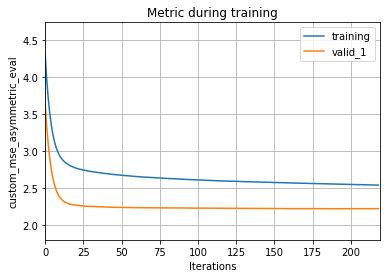

In [12]:
print('Plotting metrics recorded during training...')
ax = lgb.plot_metric(evals_result)
plt.show()

Plotting feature importances...


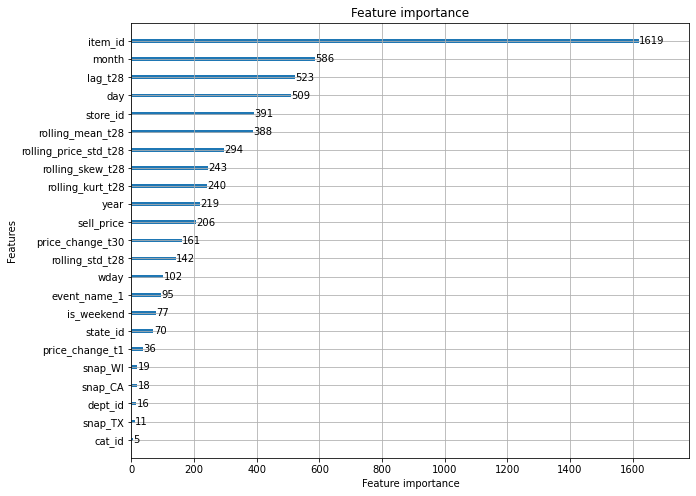

In [13]:
print('Plotting feature importances...')
ax = lgb.plot_importance(gbm, figsize=(10,8))
plt.show()

# Compute RMSSE and WRMSSE on Validation Data

In [14]:
# compute forecasts, error and map it to df_merged to get ids
df_tmp = x_val.copy()
df_tmp['y_pred'] = gbm.predict(x_val, num_iteration=gbm.best_iteration)
df_tmp['y_true'] = y_val
df_tmp['error'] = (df_tmp.y_true - df_tmp.y_pred)
df_tmp = df_tmp.merge(df_merged[['id', 'item_id','dept_id','cat_id', 'store_id', 'state_id']].drop_duplicates())

df_tmp

,item_id,dept_id,cat_id,store_id,state_id,year,month,day,is_weekend,wday,...,rolling_skew_t28,rolling_mean_t28,rolling_std_t28,price_change_t1,price_change_t30,rolling_price_std_t28,y_pred,y_true,error,id
0,1437,3,1,0,0,2016,3,28,0,3,...,1.423363,1.000000,1.231763,0.0,0.0,8.622286e-08,0.815810,1.0,0.184190,HOBBIES_1_001_CA_1_validation
1,1437,3,1,0,0,2016,3,29,0,4,...,1.310783,1.033333,1.245221,0.0,0.0,8.622286e-08,0.856239,0.0,-0.856239,HOBBIES_1_001_CA_1_validation
2,1437,3,1,0,0,2016,3,30,0,5,...,1.331552,1.000000,1.259447,0.0,0.0,8.622286e-08,0.777883,0.0,-0.777883,HOBBIES_1_001_CA_1_validation
3,1437,3,1,0,0,2016,3,31,0,6,...,1.331552,1.000000,1.259447,0.0,0.0,8.622286e-08,0.816970,0.0,-0.816970,HOBBIES_1_001_CA_1_validation
4,1437,3,1,0,0,2016,4,1,0,7,...,1.331552,1.000000,1.259447,0.0,0.0,8.622286e-08,0.962590,0.0,-0.962590,HOBBIES_1_001_CA_1_validation
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
853715,1436,2,0,9,2,2016,4,20,0,5,...,0.432608,1.766667,1.715715,0.0,0.0,0.000000e+00,1.723712,0.0,-1.723712,FOODS_3_827_WI_3_validation
853716,1436,2,0,9,2,2016,4,21,0,6,...,0.432608,1.766667,1.715715,0.0,0.0,0.000000e+00,1.618600,0.0,-1.618600,FOODS_3_827_WI_3_validation
853717,1436,2,0,9,2,2016,4,22,0,7,...,0.373565,1.833333,1.683251,0.0,0.0,0.000000e+00,1.761493,0.0,-1.761493,FOODS_3_827_WI_3_validation
853718,1436,2,0,9,2,2016,4,23,1,1,...,0.373565,1.833333,1.683251,0.0,0.0,0.000000e+00,1.953431,0.0,-1.953431,FOODS_3_827_WI_3_validation


In [38]:
# compute RMSSE and store it in dict
rmsse_dict = {}

for name, group in df_tmp.groupby(['id']):
    
    scale = scaling_factors_rmsse.loc[scaling_factors_rmsse['id'] == name]['scaling_factor'].to_list()[0]
    weight = weights_wrmsse.loc[weights_wrmsse['id'] == name]['weights'].values[0]
    
    rmsse_dict[name] = [np.sqrt(np.mean(group.error**2 / scale))]
    

In [54]:
# convert dict to dataframe
rmsse_df = pd.DataFrame(rmsse_dict).T
rmsse_df['id'] = rmsse_df.index
rmsse_df = rmsse_df.reset_index(drop=True)
rmsse_df = rmsse_df.rename(columns={0:'RMSSE'})

# add weights to df and compute weights multiplied by RMSSE
rmsse_df = rmsse_df.merge(weights_wrmsse, how='inner')
rmsse_df['w_times_RMSSE'] = rmsse_df.loc[:,'weights'] * rmsse_df.loc[:,'RMSSE']

# sort values by their impact
rmsse_df = rmsse_df.sort_values(by='RMSSE', ascending=False)


In [55]:
# compute WRMSSE
print('WRMSSE = %0.5f' % np.sum(rmsse_df.RMSSE * rmsse_df.weights))


WRMSSE = 0.88586


In [69]:
# show RMSSE and corresponding weights
rmsse_df.head(25).sort_values(by='w_times_RMSSE', ascending=False)

,RMSSE,id,item_id,weights,w_times_RMSSE
2288,3.378673,FOODS_2_013_WI_2_validation,228,0.000489,0.001652
13668,4.796989,FOODS_3_757_WI_2_validation,1366,0.000293,0.001406
20322,5.159210,HOUSEHOLD_1_032_CA_3_validation,2032,0.000218,0.001125
10348,3.203403,FOODS_3_422_WI_2_validation,1034,0.000273,0.000876
12148,3.714088,FOODS_3_602_WI_2_validation,1214,0.000167,0.000621
20324,4.233309,HOUSEHOLD_1_032_TX_1_validation,2032,0.000134,0.000568
7596,3.445830,FOODS_3_147_TX_3_validation,759,0.000157,0.000542
12726,4.115552,FOODS_3_660_TX_3_validation,1272,0.000124,0.000509
26759,3.997933,HOUSEHOLD_2_142_WI_3_validation,2675,0.000121,0.000483
12307,3.532055,FOODS_3_618_WI_1_validation,1230,0.000095,0.000334


In [71]:
# analyse time series with max. RMSSE
df_tmp.loc[df_tmp.id == rmsse_df.loc[0,'id']][['id', 'month', 'day','up_for_sale','event_name_1', 'event_type_1',
       'event_name_2', 'event_type_2','is_weekend','wday', 'sell_price', 'lag_t28', 'y_pred', 'y_true', 'error',]]

,id,month,day,up_for_sale,event_name_1,event_type_1,event_name_2,event_type_2,is_weekend,wday,sell_price,lag_t28,y_pred,y_true,error
45136,FOODS_1_001_CA_1_validation,3,28,1,13,1,3,1,0,3,2.24,1.0,0.713820,2.0,1.286180
45137,FOODS_1_001_CA_1_validation,3,29,1,13,1,3,1,0,4,2.24,0.0,0.633223,1.0,0.366777
45138,FOODS_1_001_CA_1_validation,3,30,1,13,1,3,1,0,5,2.24,1.0,0.642915,1.0,0.357085
45139,FOODS_1_001_CA_1_validation,3,31,1,13,1,3,1,0,6,2.24,0.0,0.650045,0.0,-0.650045
45140,FOODS_1_001_CA_1_validation,4,1,1,13,1,3,1,0,7,2.24,0.0,0.762316,4.0,3.237684
45141,FOODS_1_001_CA_1_validation,4,2,1,13,1,3,1,1,1,2.24,2.0,0.927933,0.0,-0.927933
45142,FOODS_1_001_CA_1_validation,4,3,1,13,1,3,1,1,2,2.24,0.0,0.807732,0.0,-0.807732
45143,FOODS_1_001_CA_1_validation,4,4,1,13,1,3,1,0,3,2.24,0.0,0.564996,4.0,3.435004
45144,FOODS_1_001_CA_1_validation,4,5,1,13,1,3,1,0,4,2.24,0.0,0.541335,1.0,0.458665
45145,FOODS_1_001_CA_1_validation,4,6,1,13,1,3,1,0,5,2.24,0.0,0.482998,3.0,2.517002


In [252]:
# analyse time series (manually)
rel_id = 'FOODS_2_181_WI_2_validation'
df_tmp.loc[df_tmp.id == rel_id][['id', 'month', 'day','up_for_sale','event_name_1', 'event_type_1',
       'event_name_2', 'event_type_2','is_weekend','wday', 'sell_price', 'lag_t28', 'y_pred', 'y_true', 'error',]]

,id,month,day,up_for_sale,event_name_1,event_type_1,event_name_2,event_type_2,is_weekend,wday,sell_price,lag_t28,y_pred,y_true,error
739172,FOODS_2_181_WI_2_validation,3,28,1,13,1,3,1,0,3,1.78,18.0,17.076136,25.0,7.923864
739173,FOODS_2_181_WI_2_validation,3,29,1,13,1,3,1,0,4,1.78,26.0,18.510598,31.0,12.489402
739174,FOODS_2_181_WI_2_validation,3,30,1,13,1,3,1,0,5,1.78,25.0,17.895362,20.0,2.104638
739175,FOODS_2_181_WI_2_validation,3,31,1,13,1,3,1,0,6,1.78,36.0,21.237320,26.0,4.762680
739176,FOODS_2_181_WI_2_validation,4,1,1,13,1,3,1,0,7,1.78,24.0,22.352143,45.0,22.647857
739177,FOODS_2_181_WI_2_validation,4,2,1,13,1,3,1,1,1,1.78,38.0,36.604713,53.0,16.395287
739178,FOODS_2_181_WI_2_validation,4,3,1,13,1,3,1,1,2,1.78,30.0,36.826474,63.0,26.173526
739179,FOODS_2_181_WI_2_validation,4,4,1,13,1,3,1,0,3,1.78,15.0,19.938193,36.0,16.061807
739180,FOODS_2_181_WI_2_validation,4,5,1,13,1,3,1,0,4,1.78,39.0,31.272036,60.0,28.727964
739181,FOODS_2_181_WI_2_validation,4,6,1,13,1,3,1,0,5,1.78,24.0,28.719215,54.0,25.280785


# Printout Forecasts

In [20]:
# map forecast values to encoded item_ids
x_pred['y_pred'] = y_pred

In [21]:
# map encoded ids to decoded ids
id_mapping_table = df_merged[['id', 'item_id', 'year', 'month', 'day','store_id']].drop_duplicates()
df_results = x_pred.merge(id_mapping_table,
                         on=['item_id', 'store_id', 'year', 'month', 'day'],
                         how='left')[[
                             'id', 'item_id', 'store_id', 'year', 'month',
                             'day', 'y_pred'
                         ]]

In [22]:
id_mapping_table

,id,item_id,year,month,day,store_id
1,HOBBIES_1_002_CA_1_validation,1438,2011,7,29,0
3,HOBBIES_1_004_CA_1_validation,1440,2011,7,29,0
4,HOBBIES_1_005_CA_1_validation,1441,2011,7,29,0
7,HOBBIES_1_008_CA_1_validation,1444,2011,7,29,0
8,HOBBIES_1_009_CA_1_validation,1445,2011,7,29,0
...,...,...,...,...,...,...
53662395,FOODS_3_823_WI_3_validation,1432,2016,5,22,9
53662396,FOODS_3_824_WI_3_validation,1433,2016,5,22,9
53662397,FOODS_3_825_WI_3_validation,1434,2016,5,22,9
53662398,FOODS_3_826_WI_3_validation,1435,2016,5,22,9


In [23]:
df_results

,id,item_id,store_id,year,month,day,y_pred
0,HOBBIES_1_001_CA_1_validation,1437,0,2016,4,25,0.751942
1,HOBBIES_1_002_CA_1_validation,1438,0,2016,4,25,0.288278
2,HOBBIES_1_003_CA_1_validation,1439,0,2016,4,25,0.502328
3,HOBBIES_1_004_CA_1_validation,1440,0,2016,4,25,1.814833
4,HOBBIES_1_005_CA_1_validation,1441,0,2016,4,25,0.866978
...,...,...,...,...,...,...,...
853715,FOODS_3_823_WI_3_validation,1432,9,2016,5,22,0.368532
853716,FOODS_3_824_WI_3_validation,1433,9,2016,5,22,0.321179
853717,FOODS_3_825_WI_3_validation,1434,9,2016,5,22,0.962030
853718,FOODS_3_826_WI_3_validation,1435,9,2016,5,22,1.381018


In [24]:
# create dict with IDs and forecasts
submission_dict = {}

for i, df in df_results.groupby(['id']):
    df = df.reset_index(drop=True)
    submission_dict[i] = df['y_pred']

In [257]:
# convert dict to dataframe
submission_df = pd.DataFrame(submission_dict).T
submission_df = submission_df.clip(lower=0) # Convert negative values to 0
submission_df.reset_index(level=0, inplace=True)
f_list = [f'F{di}' for di in list(range(1, 29))]
submission_df.columns = ['id'] + f_list
submission_df

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,FOODS_1_001_CA_1_validation,0.858151,0.784223,0.785837,0.774530,1.025715,1.076872,1.134310,1.154886,1.014241,...,1.100320,1.461315,1.261810,1.290542,1.050504,1.041482,0.927679,1.033861,1.243515,1.224790
1,FOODS_1_001_CA_2_validation,0.885983,0.855370,0.840556,0.830032,0.840136,0.943852,0.979110,0.650743,0.627539,...,0.527383,0.575730,2.813766,1.077578,0.989289,0.985842,1.263356,1.112112,1.289724,1.701910
2,FOODS_1_001_CA_3_validation,1.171029,1.085234,1.081726,0.984375,1.031229,1.260952,1.269407,1.097643,1.082551,...,1.168906,1.339741,2.991954,1.495238,1.464092,1.373278,1.373023,1.438635,1.644207,1.609040
3,FOODS_1_001_CA_4_validation,0.630838,0.499347,0.500961,0.500961,0.541919,0.604250,0.570014,0.645492,0.594311,...,0.334172,0.379768,0.379470,0.438439,0.246882,0.243435,0.243179,0.319304,0.373913,0.419203
4,FOODS_1_001_TX_1_validation,0.559423,0.513776,0.515390,0.515390,0.563675,0.626007,0.694336,0.647058,0.501952,...,0.307804,0.363609,0.372852,0.288140,0.220147,0.205875,0.205619,0.225075,0.279684,0.269321
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,HOUSEHOLD_2_516_TX_2_validation,0.267271,0.221624,0.234545,0.234545,0.271523,0.343166,0.389830,0.338559,0.323268,...,0.320661,0.472934,0.429672,0.289895,0.237371,0.265349,0.237116,0.263899,0.327819,0.300065
30486,HOUSEHOLD_2_516_TX_3_validation,0.167555,0.162044,0.169232,0.152351,0.179135,0.216927,0.203254,0.168142,0.204941,...,0.588423,0.227188,0.441437,0.390412,0.374430,0.374430,0.356459,0.375915,0.413312,0.413312
30487,HOUSEHOLD_2_516_WI_1_validation,0.121399,0.104581,0.106195,0.106195,0.139659,0.229158,0.226009,0.142873,0.141171,...,0.190320,0.221455,0.230832,0.121419,0.105436,0.105436,0.105181,0.138645,0.220421,0.220421
30488,HOUSEHOLD_2_516_WI_2_validation,0.131873,0.115055,0.116669,0.116669,0.136125,0.174037,0.170888,0.153347,0.151645,...,0.118331,0.149717,0.159094,0.115276,0.099293,0.099293,0.126961,0.135111,0.165300,0.165300


# Increase Predictions for Food Items as they are underestimated

In [258]:
food_list = []
for i in rmsse_df.head(50).itertuples():
    if 'FOODS' in i.id:
        food_list.append(i.id)

In [259]:
submission_df.loc[submission_df.id.isin(food_list),
                  f_list] = submission_df.loc[submission_df.id.isin(food_list),
                                            f_list] * 1.4

submission_df

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,FOODS_1_001_CA_1_validation,0.858151,0.784223,0.785837,0.774530,1.025715,1.076872,1.134310,1.154886,1.014241,...,1.100320,1.461315,1.261810,1.290542,1.050504,1.041482,0.927679,1.033861,1.243515,1.224790
1,FOODS_1_001_CA_2_validation,0.885983,0.855370,0.840556,0.830032,0.840136,0.943852,0.979110,0.650743,0.627539,...,0.527383,0.575730,2.813766,1.077578,0.989289,0.985842,1.263356,1.112112,1.289724,1.701910
2,FOODS_1_001_CA_3_validation,1.171029,1.085234,1.081726,0.984375,1.031229,1.260952,1.269407,1.097643,1.082551,...,1.168906,1.339741,2.991954,1.495238,1.464092,1.373278,1.373023,1.438635,1.644207,1.609040
3,FOODS_1_001_CA_4_validation,0.630838,0.499347,0.500961,0.500961,0.541919,0.604250,0.570014,0.645492,0.594311,...,0.334172,0.379768,0.379470,0.438439,0.246882,0.243435,0.243179,0.319304,0.373913,0.419203
4,FOODS_1_001_TX_1_validation,0.559423,0.513776,0.515390,0.515390,0.563675,0.626007,0.694336,0.647058,0.501952,...,0.307804,0.363609,0.372852,0.288140,0.220147,0.205875,0.205619,0.225075,0.279684,0.269321
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,HOUSEHOLD_2_516_TX_2_validation,0.267271,0.221624,0.234545,0.234545,0.271523,0.343166,0.389830,0.338559,0.323268,...,0.320661,0.472934,0.429672,0.289895,0.237371,0.265349,0.237116,0.263899,0.327819,0.300065
30486,HOUSEHOLD_2_516_TX_3_validation,0.167555,0.162044,0.169232,0.152351,0.179135,0.216927,0.203254,0.168142,0.204941,...,0.588423,0.227188,0.441437,0.390412,0.374430,0.374430,0.356459,0.375915,0.413312,0.413312
30487,HOUSEHOLD_2_516_WI_1_validation,0.121399,0.104581,0.106195,0.106195,0.139659,0.229158,0.226009,0.142873,0.141171,...,0.190320,0.221455,0.230832,0.121419,0.105436,0.105436,0.105181,0.138645,0.220421,0.220421
30488,HOUSEHOLD_2_516_WI_2_validation,0.131873,0.115055,0.116669,0.116669,0.136125,0.174037,0.170888,0.153347,0.151645,...,0.118331,0.149717,0.159094,0.115276,0.099293,0.099293,0.126961,0.135111,0.165300,0.165300


# Submit to Kaggle 

In [224]:
if submit_to_kaggle:
    # Bring data to Kaggel's required form (evaluation & validation)
    df_submission = submission_df.append(
        submission_df.replace(to_replace='validation', value='evaluation',
                              regex=True))
    filename = utils.get_m5_root_dir(
    ) + '/data/submissions/gradient_boosting_regressor_v_2_5.csv'
    df_submission.to_csv(filename, index=False)
    

    # Submit via Kaggle API or with website https://www.kaggle.com/c/m5-forecasting-accuracy/submissions
    !kaggle competitions submit -c m5-forecasting-accuracy -f data/submissions/gradient_boosting_regressor_v_2_5.csv -m "asymetric loss with factor 1.1 if res > 1"


In [260]:
df_submission = submission_df.append(
    submission_df.replace(to_replace='validation', value='evaluation',
                          regex=True))
filename = utils.get_m5_root_dir(
) + '/data/submissions/gradient_boosting_regressor_v_2_5.csv'
df_submission.to_csv(filename, index=False)